In [5]:
%matplotlib inline
from tensorscaling import scale, unit_tensor, random_tensor, marginal
import numpy as np
import matplotlib.pyplot as plt

# Tensor scaling

Scale 3x3x3 unit tensor to certain non-uniform marginals:

In [ ]:
shape = [3, 3, 3]
targets = [(.5, .25, .25), (.4, .3, .3), (.7, .2, .1)]

res = scale(unit_tensor(3, 3), targets, eps=1e-4)
res

We can also access the scaling matrices and the final scaled state:

In [ ]:
print(res.gs[0], "\n")
print(res.gs[1], "\n")
print(res.gs[2])

Let's now check that the W tensor *cannot* be scaled to uniform marginals:

In [ ]:
shape = [2, 2, 2, 2]
W = np.zeros(shape)
W[1, 0, 0, 0] = W[0, 1, 0, 0] = W[0, 0, 1, 0] = W[0, 0, 0, 1] = .5
targets = [(.5, .5)] * 4

scale(W, targets, eps=1e-4, max_iterations=1000)

To see more clearly what is going on, we can set the `verbose` flag:

In [ ]:
res = scale(W, targets, eps=1e-4, max_iterations=10, verbose=True)

We see that at each point in the algorithm, one of the marginals has Frobenius distance $\approx 0.59$ to being uniform. Indeed, we know that the entanglement polytope of the W tensor does not include the point corresponding to uniform marginals -- see [here](https://www.entanglement-polytopes.org/four_qubits) for an interactive visualization!

# Tuples of matrices and tensors

We can just as well only prescribe the desired spectra for subsystems.
Note that prescribing two out of three marginals amounts to *operator scaling*.

In [ ]:
shape = [3, 3, 3]
targets = [(.4, .3, .3), (.7, .2, .1)]

res = scale(unit_tensor(3, 3), targets, eps=1e-6)
res

Indeed, the last two marginals are as prescribed, while the first marginal is arbitrary.

In [ ]:
print(marginal(res.psi, 0).round(5), "\n")
print(marginal(res.psi, 1).round(5), "\n")
print(marginal(res.psi, 2).round(5))

# Gradient descent 

In [2]:


def rand_3tensor_unif(n):
    start = random_tensor([n,n,n])
    targets = [np.ones(n)/n,np.ones(n)/n,np.ones(n)/n]
    res, norms, frobs = scale(start, targets, eps=1e-4, method = "gradient")
    lognorm = []
    for norm in norms:
        lognorm.append(np.log(norm))
        #norm = np.log(norm)
    return lognorm

In [3]:
def rand_3tensor_ratio(n):
    start = random_tensor([n,n,n])
    targets = [np.ones(n)/n,np.ones(n)/n,np.ones(n)/n]
    res, norms, frobs = scale(start, targets, eps=1e-4, method = "gradient")
    ratios = []
    #lognorms = []
    #logfrobs = []
    for i in range(len(norms)):
        ratios.append(norms[i]**2/(frobs[i]**2))
        #lognorms.append(np.log(norms[i]-(1/n)))
        #logfrobs.append(np.log(frobs[i]))
        #norm = np.log(norm)
    return ratios, frobs, norms

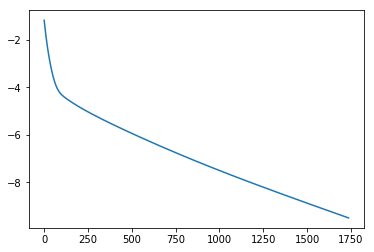

In [4]:
#plots log of (spectral norm -1) of the first marginal
norms = rand_3tensor_unif(3)
plt.plot(norms)

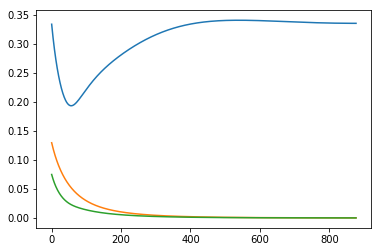

In [12]:
ratios, frobs, norms = rand_3tensor_ratio(8)
plt.plot(ratios)
plt.plot(frobs)
plt.plot(norms)

In [ ]:
np.linalg.eigvalsh(np.matrix([[1,0],[0,2]]))

# Decoherence

In [57]:
# random tensor 
dimension = 100
samples = 100
#x = random_tensor([n,n,2])
#marginal(x,0)
kraus_list = list(np.random.randn(dimension,dimension) for i in range(samples))
muA = sum(kraus@kraus.T for kraus in kraus_list)
muA = muA - np.trace(muA)/dimension
muB = sum(kraus.T @kraus for kraus in kraus_list)
TmuB = sum(kraus @ muB @ kraus.T for kraus in kraus_list)
valA, basisA = np.linalg.eigh(muA)
valB, basisB = np.linalg.eigh(TmuB)
dotlist = []
for a in basisA:
    for b in basisB:
        dotlist.append(np.abs(np.dot(a,b)))
np.max(dotlist)

0.4376380832525713

In [123]:
def decoherence(samples,dimension, runs):
    run_list = []
    for i in range(runs):
        kraus_list = list(np.random.randn(dimension,dimension) for i in range(samples))
        muA = sum(kraus@kraus.T for kraus in kraus_list)
        muA = muA - np.trace(muA)*np.eye(dimension)/dimension
        muB = sum(kraus.T @kraus for kraus in kraus_list)
        muB = muB- np.trace(muB)*np.eye(dimension)/dimension
        TmuB = sum(kraus @ muB @ kraus.T for kraus in kraus_list)
        valA, basisA = np.linalg.eigh(muA)
        #print(valA)
        valB, basisB = np.linalg.eigh(TmuB)
        dotlist = []
        for a in basisA.T:
            #print(a)
            for b in basisB.T:
                dotlist.append(np.abs(np.dot(a,b)))
        #print(np.max(dotlist))
        run_list.append(np.max(dotlist))
    return run_list

def maxdecoherence(samples,dimension, runs):
    run_list = []
    for i in range(runs):
        kraus_list = list(np.random.randn(dimension,dimension) for i in range(samples))
        muA = sum(kraus@kraus.T for kraus in kraus_list)
        muA = muA - np.trace(muA)*np.eye(dimension)/dimension
        muB = sum(kraus.T @kraus for kraus in kraus_list)
        muB = muB- np.trace(muB)*np.eye(dimension)/dimension
        TmuB = sum(kraus @ muB @ kraus.T for kraus in kraus_list)
        valA, basisA = np.linalg.eigh(muA)
        #print(valA)
        valB, basisB = np.linalg.eigh(TmuB)
        dotlist = []
        
            #print(a)
        for b in basisB.T:
            dotlist.append(np.abs(np.dot(basisA.T[-1],b)))
        #print(np.max(dotlist))
        run_list.append(np.max(dotlist))
    return run_list

def otherdecoherence(samples,dimension, runs):
    run_list = []
    for i in range(runs):
        kraus_list = list(np.random.randn(dimension,dimension) for i in range(samples))
        muA = sum(kraus@kraus.T for kraus in kraus_list)
        muA = muA - np.trace(muA)*np.eye(dimension)/dimension
        muB = sum(kraus.T @kraus for kraus in kraus_list)
        muB = muB- np.trace(muB)*np.eye(dimension)/dimension
        TmuB = sum(kraus @ muB @ kraus.T for kraus in kraus_list)
        TmuB = TmuB - np.trace(TmuB)*np.eye(dimension)/dimension
        TmuB = TmuB/np.linalg.norm(TmuB)
        valA, basisA = np.linalg.eigh(muA)
        #print(valA)
        #valB, basisB = np.linalg.eigh(TmuB)
        #dotlist = []
        u = basisA.T[-1]
        term = np.dot(u, TmuB @ u)
        
            #print(a)
        #for b in basisB.T:
        #    dotlist.append(np.abs(np.dot(basisA.T[-1],b)))
        #print(np.max(dotlist))
        run_list.append(term)
    return run_list

(array([2., 1., 2., 2., 0., 1., 0., 0., 1., 1.]),
 array([0.17453044, 0.18659853, 0.19866663, 0.21073473, 0.22280282,
        0.23487092, 0.24693902, 0.25900711, 0.27107521, 0.28314331,
        0.29521141]),
 <a list of 10 Patch objects>)

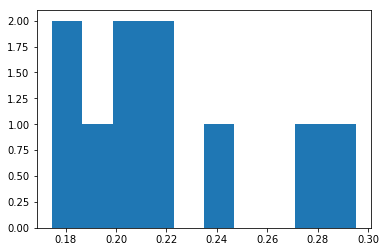

In [114]:
x = maxdecoherence(20,900,10)
plt.hist(x)

(array([2., 0., 1., 1., 3., 1., 1., 0., 0., 1.]),
 array([0.04796303, 0.04888962, 0.04981621, 0.0507428 , 0.0516694 ,
        0.05259599, 0.05352258, 0.05444917, 0.05537576, 0.05630235,
        0.05722895]),
 <a list of 10 Patch objects>)

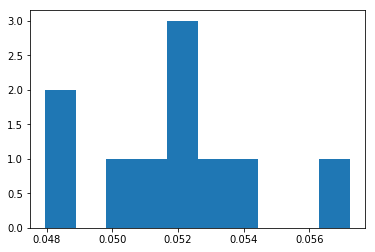

In [130]:
x = otherdecoherence(10,900,10)
plt.hist(x)